# 2. Feature extraction and fusion for unimodal classification

<a id='task2'></a>
<div class=" alert alert-warning">
    <b>Assigment.</b> <b>Task 2.</b>

Use the training dataset prepared in task 1. to build models based on the combination of principal component analysis (PCA), linear discriminant analysis (LDA), and nearest neighbour (NN) classifier for each modality separately and evaluate the model on test dataset. Do the subtasks given as
<br>
<br>
<p> <b>2.1</b> Calculate PCA and LDA transformations to reduce the dimensionality of accelerometer data (e.g., using scikit-learn implementations). Before transformations downsample data from 100 Hz to 25 Hz (using scipy.signal.resample) to get 125x3 matrix of data for each 5 sec window. You should also standardize the values to zero mean and unit variance before the transformations. Using training dataset, fit PCA with 5-dimensional subspace (i.e., choosing the 5 largest principal components) and fit LDA with 5-dimensional subspace. Transform both train and test examples to this low-dimensional feature representation. Concatenate each sequence to single vector size of 3x(5+5). Perform the fusion of PCA and LDA similar manner as presented in Lecture 3 (pages 24-25) using NN method. Evaluate the performance on testset. Show confusion matrix and F1 scores of the results. </p>
<br>
<p> <b>2.2</b> Use PCA and LDA transformations to reduce the dimensionality of depth images. You should also standardize the values to zero mean and unit variance before the transformations. Fit PCA and LDA for all training images (12x16, 192-dimensional in vectorized form) by choosing 5-dimensional subspace for both PCA and LDA. Transform both train and test examples to this low-dimensional feature representation. Concatenate each sequence to single vector size of 5x1x(5+5). Similar to task 2.1, do the PCA and LDA fusion using NN and evaluate the performance on testset. Show confusion matrix and F1 scores of the results. </p>
<br>
Document your work, evaluate the results, and analyse the outcomes in each subtasks 2.1-2.2.

</div>

## 2.1 Calculate PCA and LDA transformations to reduce the dimensionality of accelerometer data

#### Run task one first to get training and testing records (Task 1.2)
If you have run task one yourself before you can skip the following cell

In [2]:
%%capture
%run ./slovo_one.ipynb

In [3]:
# Load training and testing data from task one:
%store -r training_records
training_records = training_records
%store -r testing_records
testing_records = testing_records

In [4]:
# 2.1 Imports:
import importlib, utilities.fun_two, utilities.fun_one
importlib.reload(utilities.fun_two)
importlib.reload(utilities.fun_one)
from utilities.fun_two import acccelerometer_resample, PcaActApplier, LdaActApplier, act_fusion, Standardizer
from utilities.fun_one import visualize
import time
import pandas as pd

#### Resample the data:

In [5]:
### Your code begins here ###
#Measure time
start_time = time.time()
# number of samples to be left in a window
resample_samples = 125
# Resample training data using signal's resample:
act_train = pd.DataFrame()
act_train['df'] = acccelerometer_resample(training_records,resample_samples)
train_labels = training_records[training_records.sensor_code=='act'].exercise_id.apply(lambda x: int(x))
# Resample testing data:
act_test = pd.DataFrame()
act_test['df'] = acccelerometer_resample(testing_records,resample_samples)
#Get Labels:
test_labels = testing_records[testing_records.sensor_code=='act'].exercise_id.apply(lambda x: int(x))
end_time = time.time()
print("Execution Time: ", end_time - start_time)

Execution Time:  0.983834981918335


#### Standardize the Data:

In [6]:
#Measure time
start_time = time.time()
# Create a Standardizer:
act_s = Standardizer()
# Calculate mean and std on training set:
act_s.fit(act_train)
# Using mean and std standardize training set:
act_train['df'] = act_s.transform(act_train)
# Using training set mean and std standardize test set:
act_test['df'] = act_s.transform(act_test)
# Measure execution time
end_time = time.time()
print("Execution Time: ", end_time - start_time)

Execution Time:  0.6528000831604004


#### Apply the PCA - calculate 5 principal components:

In [7]:
#Measure time
start_time = time.time()
# choose 5 principal components:
n_components = 5
# Create Pca decorator class object:
pca = PcaActApplier(n_components)
# Fit the PCA with the training data
pca.fit(act_train['df'])
# Apply PCA on both training and testing data:
act_pca_train = pca.transform(act_train['df'])
act_pca_test = pca.transform(act_test['df'])
# Measure execution time
end_time = time.time()
print("Execution Time: ", end_time - start_time)

Execution Time:  7.711384057998657


#### Apply the LDA:

In [8]:
# Measure time
start_time = time.time()
# LDA, number of components for dimensionality reduction:
n_components = 5
# LDA decorator:
lda = LdaActApplier(n_components)
# Fit with training data:
lda.fit(act_train['df'],train_labels)
# Transform both sets:
act_lda_train = lda.transform(act_train['df'])
act_lda_test = lda.transform(act_test['df'])
# Measure execution time:
end_time = time.time()
print("Execution Time: ", end_time - start_time)

Execution Time:  2.4574038982391357


#### PCA and LDA Fusion of accelerometer data

In [9]:
# Measure time
start_time = time.time()
# Fuse training pca and lda to get a NN classification for comparison:
train_pred_labels = act_fusion(act_pca_train,act_lda_train,act_pca_train,act_lda_train,train_labels)
# Fuse testing data to get testing label predictions:
test_pred_labels = act_fusion(act_pca_train,act_lda_train,act_pca_test,act_lda_test,train_labels)
# Measure execution time:
end_time = time.time()
print("Execution Time: ", end_time - start_time)

Execution Time:  43.98286414146423


#### Visualisation of the nearest neighbour classification on the accelerometer data:

Accelerometer sensor used to classify the exercises
Training data F1 score =  1.0
Testing data F1 score =  0.46161318020053904


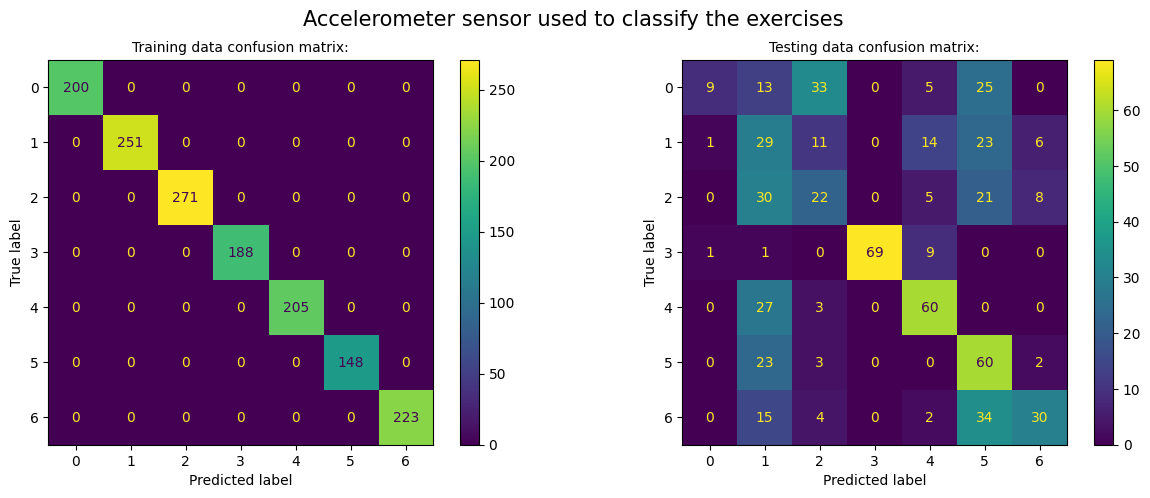

In [10]:
# Run visualize function (prints confusion matrix and calculates f1 score)
# To see how predicted labels on testing data are correct
visualize(train_pred_labels,train_labels,test_pred_labels,test_labels,main_title="Accelerometer sensor used to classify the exercises")
### Your code ends here ###

## Task 2.1 review

Classification using NN algorithm showed 100% F1 score on training data and only 46% on testing data.

The score on training data is understandable, as the distance between test sample and train sample is 0. That's because we are comparing distances of the same dataset. At least it proves that the NN algorithm works.

Performance of the NN algorithm on the test set is disappointing. 46% would not be enough for real world application. Probably because founding our label estimation based only on the nearest neighbour is too confident. It is needed to use some more sophisticated classifier. From the confusion matrix we can see that some of the exercises (exercise with label 3) were more easy to distinguish than others (exercise with label 1).

## 2.2 Use PCA and LDA transformations to reduce the dimensionality of depth images

In [11]:
# 2.2 Imports:
import importlib, utilities.fun_two, utilities.fun_one
importlib.reload(utilities.fun_two)
importlib.reload(utilities.fun_one)
from utilities.fun_two import concat_pca_lda, PcaDcApplier, LdaDcApplier, classifyNN, Standardizer
from utilities.fun_one import visualize

#### Split the data, so we work only with Depth sensor modality

In [12]:
### Your code begins here ###
start_time = time.time() # Measure execution time

'''Work only with rows with dc'''
dc_train_records = training_records[training_records['sensor'] == 'dc']
dc_test_records = testing_records[testing_records['sensor'] == 'dc']

reduced_dimensions = 5

end_time = time.time()
print("Execution Time: ", end_time - start_time)

Execution Time:  0.002866983413696289


#### Standardize the Data:

In [13]:
start_time = time.time() # Measure execution time

'''Standardize the dc data'''
standardizer = Standardizer()
standardizer.fit(dc_train_records)
standardized_dc_train_records = standardizer.transform(dc_train_records)
standardized_dc_test_records = standardizer.transform(dc_test_records)

end_time = time.time() # Measure execution time
print("Execution Time: ", end_time - start_time)

Execution Time:  1.1413891315460205


#### Apply PCA to the data:

In [14]:
start_time = time.time() # Measure execution time

'''Fit PCA for depth sensor on standardized train dataset and transform test an train dataset'''
pca_applier = PcaDcApplier(reduced_dimensions)
pca_applier.fit(standardized_dc_train_records)

pca_dc_train_records = pca_applier.transform(standardized_dc_train_records)
pca_dc_test_records = pca_applier.transform(standardized_dc_test_records)

end_time = time.time() # Measure execution time
print("Execution Time: ", end_time - start_time)

Execution Time:  6.730000972747803


#### Apply PCA to the data:

In [15]:
start_time = time.time() # Measure execution time

'''Fit PCA for depth sensor on standardized train dataset and transform test an train dataset'''
lda_applier = LdaDcApplier(reduced_dimensions)
lda_applier.fit(standardized_dc_train_records)

lda_dc_train_records = lda_applier.transform(standardized_dc_train_records)
lda_dc_test_records = lda_applier.transform(standardized_dc_test_records)

end_time = time.time() # Measure execution time
print("Execution Time: ", end_time - start_time)

Execution Time:  5.352895975112915


#### Concatenate PCA and LDA to one feature vector of size 1*50 5 images * (5 PCA features + 5 LDA features)

In [16]:
start_time = time.time() # Measure execution time
'''Concatenate PCA and LDA features of depth sensor data'''
concat_dc_train_records = concat_pca_lda(pca_dc_train_records, lda_dc_train_records)
concat_dc_test_records = concat_pca_lda(pca_dc_test_records, lda_dc_test_records)

end_time = time.time() # Measure execution time
print("Execution Time: ", end_time - start_time)

Execution Time:  0.18450307846069336


In [17]:
start_time = time.time() # Measure execution time

'''Get estimated labels for train dataset calculated by Nearest Neighbour algorithm on depth sensor data'''
est_train_labels = classifyNN(train_data = concat_dc_train_records, test_data=concat_dc_train_records)

end_time = time.time() # Measure execution time
print("Execution Time: ", end_time - start_time)

Execution Time:  508.3992519378662


In [18]:
start_time = time.time() # Measure execution time

'''Get estimated labels for test dataset calculated by Nearest Neighbour algorithm on depth sensor data'''
est_test_labels = classifyNN(train_data = concat_dc_train_records, test_data=concat_dc_test_records)

end_time = time.time() # Measure execution time
print("Execution Time: ", end_time - start_time)

Execution Time:  249.1290168762207


Depth sensor used to classify the exercises
Training data F1 score =  1.0
Testing data F1 score =  0.503287021228411


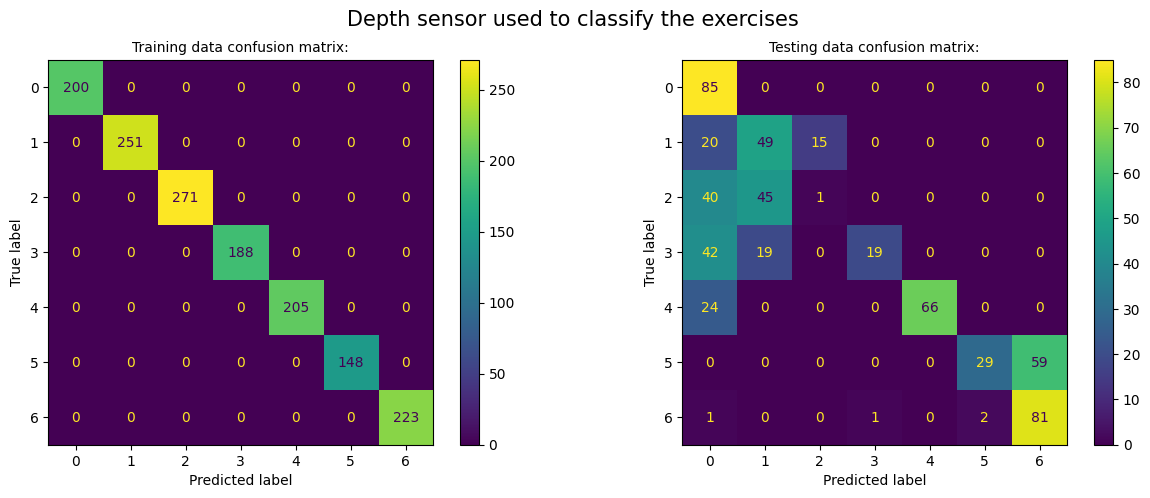

In [19]:
'''Visualize the results of NN classification for depth sensor data'''
visualize(est_train_labels['estimated_label'],est_train_labels['real_label'],est_test_labels['estimated_label'],est_test_labels['real_label'],main_title="Depth sensor used to classify the exercises")
### Your code ends here ###

## Task 2.2 review

Classification using NN algorithm again showed 100% F1 score on training data and only a little over 50% on testing data.

The score on training data is again understandable, as we are comparing distances of the same dataset, so the nearest neighbour has distance 0. At least it proves that the implementation of NN algorithm for depth sensor works.

50% F1 score is slightly better than classification results on the acclerometer, but it would not be enough for real world application either. It is needed to use some more sophisticated classifier.

From the confusion matrix we can see big differences from accelerometer confusion matrix. The performance over specific exercises changed. Eg for exercise with label 6 (label '07' in original dataset) was better classified by nn on depth sensor data and exercise with label 3 (label '04' in original dataset) was better classified by nn on accelerometer data. **This suggests that modality fusion may positively affect the overall performance.**